## Import Packages

In [26]:
# Import python packages and modules
import pandas as pd
import ipywidgets as w
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from IPython.display import clear_output

# required packages for web scraping
from urllib.request import urlopen
from bs4 import BeautifulSoup
from unicodedata import normalize

## Add maps

In [27]:
url_map = {
    'nba_teams_url' : 'https://en.wikipedia.org/wiki/Wikipedia'  \
    ':WikiProject_National_Basketball_Association/National_Basketball_Association_team_abbreviations',
    'team_stats_url' : 'https://www.basketball-reference.com/{}/NBA_{}.html',
    'player_basic_stats_url' : 'https://www.basketball-reference.com/{}/NBA_{}_per_game.html',
    'player_advanced_stats_url' : 'https://www.basketball-reference.com/{}/NBA_{}_advanced.html'
    
}

table_map = {
    1 : 'team-stats-per_game',
    2 : 'per_game_stats',
    3 : 'advanced_stats'
}

locator_map = {
    1 : 'id',
    2 : 'class'
}

## Add auxiliary classes

In [28]:
# Filter data set on specific conditions
class Thresholds:
    
    def __init__(self, games, mpg, tov):
        self.games = games  # Number of games played
        self.mpg = mpg  # Average number of minutes played per game
        self.tov = tov  # Average number of turnovers made per game

## Add auxiliary functions

In [29]:
def get_nba_teams(url):        
    """
    Get a wikipedia page and map NBA team abbreviations to franchises.
    """
    
    html = urlopen(url)
    soup = BeautifulSoup(html)
    # class is specific to wiki page
    rows = soup.find('table', {'class':'wikitable sortable'}).find('tbody').findAll('tr')
    # first line is header / use strip for newlines
    headers = [td.getText().strip() for td in rows[0].findAll('td')]
    # get the text from all <td> items
    teams = [
        [td.getText().strip() for td in rows[i].findAll('td')] for i in range(1, len(rows))
    ]
    
    # construct new dict and create a map between abbreviation and team name
    new_dict = {}
    for k,v in pd.DataFrame(teams, columns = headers).set_index('Franchise').to_dict().items():
        for k,v in v.items():
            new_dict[k] = v

    return new_dict


def get_stats(url, locator_type, *argv):    
    """ 
    Get basic and advanced stats for teams and players using web scraping module BeatifoulSoup.
    For each url passed the needed information is scrapped by various HTML tables.
    """
    # Get the variable arguments in a list
    auxls = []
    for arg in argv:        
        auxls.append(arg)
        
    # Currently checking playoffs; later could be league statistics 
    final_url=url.format('leagues' if auxls[0] == True else 'playoffs', auxls[1])
    
    # URL pages we will scraping. This is the HTML for the given URL
    html = urlopen(final_url)
    soup = BeautifulSoup(html)
    table = soup.find('table', {locator_map[locator_type]:auxls[2]})

    # use getText()to extract the text we need into a list
    # and normalize to transform \xa0 character to space and later on remove it completely    
    headers = [normalize('NFKD', th.getText()) for th in soup.find('table', id=auxls[2]).find('thead').findAll('th')]
    # exclude the first column as we will not need the ranking order from Basketball Reference for the analysis
    headers = headers[1:]    
    
    # avoid the first header row
    # rows = soup.findAll('tr')[1:]
    rows = soup.find('table', id=auxls[2]).find('tbody').findAll('tr')
    # rows = soup.find('table', id="team-stats-per_game").soup.findAll('tr')[1:]
    team_stats = [[td.getText() for td in rows[i].findAll('td')]
                  for i in range(len(rows))]

    return pd.DataFrame(team_stats, columns = headers)

## Formatter functions

In [30]:
# Used to format the data from the HTML tables

def team_data_format(df):
    """ 
    Used to format general team data of the 16 NBA playoffs contestents. 
    Gets a data frame with the raw data and returns a modified data frame.
    """
    # using the following return with warning "settingwithcopywarning"
    # df = df[df.Team != 'League Average']    
    df.drop(index=df[df['Team'] == 'League Average'].index, inplace=True)
    # map each Franchise Team Name to an abbreviation according to Wikipedia
    df.Team = df.Team.map(get_nba_teams(url_map['nba_teams_url']))    
    
    # transform numeric columns to float64 or int64
    numCols = [ elem for elem in df.columns if elem not in ['Team']]    
    df[numCols] = df[numCols].apply(pd.to_numeric, errors='coerce')
    # multiply by 100 for percentages (for better visualization)
    df.loc[:,df.filter(regex='%$').columns] = df.filter(regex='%$').apply(lambda x: x*100)
    
    return df


def player_basic_data_format(df):
    """ 
    Used to format basic player data. 
    Gets a data frame with the raw data and returns a modified data frame.
    """
    # transform numeric columns to float64 or int64
    numCols = [ elem for elem in df.columns if elem not in ['Player', 'Pos', 'Tm']]    
    df[numCols] = df[numCols].apply(pd.to_numeric, errors='coerce')
    # multiply by 100 for percentages (for better visualization)
    df.loc[:,df.filter(regex='%$').columns] = df.filter(regex='%$').apply(lambda x: x*100)            
    # rename columns
    df = df.rename(columns={'Tm':'Team'})
    
    return df


def player_advanced_data_format(df):
    """ 
    Used to format advanced player data. 
    Gets a data frame with the raw data and returns a modified data frame.
    """
    # drop empty columns: Identify the columns that have only 1 space character and drop them
    idx = [icol for icol, e in enumerate(df.columns.get_loc(chr(32))) if e == True]        
    df.drop(df.columns[idx], axis = 1, inplace = True) 
    
    # transform numeric columns to float64 or int64
    numCols = [ elem for elem in df.columns if elem not in ['Player', 'Pos', 'Tm']]        
    df[numCols] = df[numCols].apply(pd.to_numeric, errors='coerce')
    # multiply by 100 for percentages (for better visualization)
    df.loc[:,'TS%'] = df['TS%'].apply(lambda x: x*100)
    # rename columns
    df = df.rename(columns={'Tm': 'Team',
                            'MP': 'Total MP'
                           })
    
    return df


# Define dispatch dictionary
formatDict = {
    'team' : team_data_format,
    'player_basic' : player_basic_data_format,
    'player_advanced' : player_advanced_data_format
}

## Load dataset
The following cell contain retrieves player and team data using web scraping packages. Data retrieval is separated to:
* Team data
* Player basic statistics (e.g. FT%, FG%, etc)
* Player advanced statistics (e.g. )
* Additional metrics which was not readily available (i.e. extensive manipulation of the HTML content was needed, hence it was more sufficient to create the metrics from its individual components)

In [35]:
# Static parameters
# year: Year of reference
# season: {season: True, playoffs: False}
# locator_type: HTML component related {1: id, 2: class}
year = 2019
season = False
locator_type = 1

# Get Team data
team_data = formatDict['team'](get_stats(url_map['team_stats_url'], locator_type, season, year, table_map[1]))
# team_data.head(20)

# Get each player's simple statistics
player_basic_data = formatDict['player_basic'](get_stats(url_map['player_basic_stats_url'], locator_type, season, year, table_map[2]))
# player_basic_data.head(10)

# Get eachplayer's advanced statistics 
player_advanced_data = formatDict['player_advanced'](get_stats(url_map['player_advanced_stats_url'], locator_type, season, year, table_map[3]))
# player_advanced_data.head(10)

# Merge player data
player_all_data = pd.merge(player_basic_data, player_advanced_data,  \
                           on=['Player', 'Pos', 'Team', 'Age', 'G']).dropna(how='all')
# player_all_data.head(30)

# Metrics added:

# eFG%: Effective FG percentage
team_data['eFG%'] = team_data.apply(lambda row: ((row['FG'] + 0.5*row['3P']) / row['FGA'])*100, axis=1)

# Assists Rate: Create new column for report #3
player_all_data = pd.merge(player_all_data, team_data.loc[:, ['Team', 'MP', 'FG']], on='Team')  \
.rename(columns={'MP_y': 'Team MP',  \
                 'FG_y': 'Team FG',  \
                 'MP_x': 'MP',  \
                 'FG_x': 'FG'  \
                })
player_all_data['Assists Rate'] = player_all_data.  \
apply(lambda row: 100*row['AST'] / (((row['MP'] / (row['Team MP'] / 5)) * row['Team FG']) - row['FG'])   \
if row['TOV'] != 0 else 0.0, axis=1)
# player_all_data.head(30)

## Report 1: Shooting Percentage Comparison

This report will compare the sixteen playoff team in the following metrics:
* FT%: Free Throw percentage
* 2P%: 2-point percentage
* 3P%: 3-point percentage
* FG%: Field Goal percentage (2-point and 3-point percentage combined)
* eFG%: Effective Field Goal percentage.

Although the metrics 2P% and 3P% may provide some insight, long now have been indequate for a detailed analysis on the shooting perfomance of a team. Instead two more metrics have been added FG% (which takes into consideration the combination of 2P and 3P) and more important the effective FG percentage.

Effective Field Goal Percentage: As per [NBA.com](https://stats.nba.com/help/glossary/#efgpct) glossary, the effective field goal percentage is used to calculate the field goal percentage adjusting by made 3-point field goals being 1.5 times more valuable than made 2-point field. Therefore it is more reasonable for a team that is performing better in 3-pointers to be _more effective_ in scoring that a team that is usually a 2-pointer team. The formula to calculate the effective field goal percentage is:
\begin{equation}
eFG = \frac{FGM + (0.5*3PM)}{FGA}
\end{equation}
where:
* FGM: Field Goal Attempts Made
* 3PM: 3-Point Attempts Made
* FGA: Field Goals Attempted

Since the 3-point shoots are considered 1.5 times more than 2-point, it is reasonable that the eFG% is higher than the traditional FG%. The more the 3-point shoots attempted by a team the higher the margin between the typical FG% and eFG%. These two metrics FG% and eFG% are made equal when a team (or in an analogy player) does not shoot any 3-point shoots.

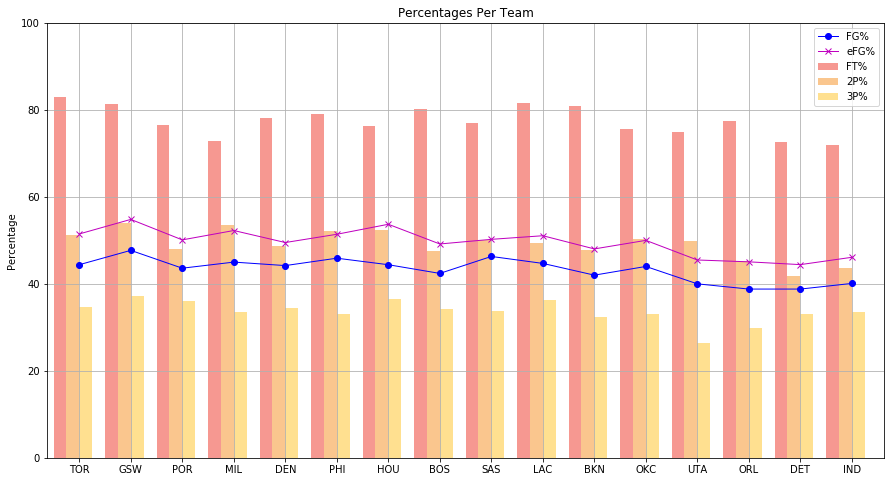

In [32]:
pos = list(range(len(team_data['FT%'])))
width = 0.25  # width of each bar 
    
# Plotting
fig, ax = plt.subplots(figsize=(15,8))

# Create a bar with FT% data,
# in position pos,
plt.bar(pos,         
        team_data['FT%'], 
        # of width
        width, 
        # with alpha 0.5 (sets the transparency level)
        alpha=0.5, 
        # with color
        color='#EE3224', 
        # with label
        label=team_data['Team'][0]) 

# Create a second bar with 2P% data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos],  # this is a list see more on list comprehension        
        team_data['2P%'],        
        width,         
        alpha=0.5,         
        color='#F78F1E',         
        label=team_data['Team'][1]) 

# Create a bar with 3P% data,
plt.bar([p + width*2 for p in pos],         
        team_data['3P%'],         
        width,         
        alpha=0.5,         
        color='#FFC222',         
        label=team_data['Team'][2]) 

# Set the y axis label
ax.set_ylabel('Percentage')

# Set the chart's title
ax.set_title('Percentages Per Team')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(team_data['Team'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)  # if not set the edges will be too far away
plt.ylim([0, 100])

ax.plot(ax.get_xticks()
        , team_data['FG%'].values
        , linestyle='-'
        , marker='o'
        , color='b'
        , linewidth=1.0
        , label='FG%')

ax.plot(ax.get_xticks()
        , team_data['eFG%'].values
        , linestyle='-'
        , marker='x'
        , color='m'
        , linewidth=1.0
        , label='eFG%')

# Set the legend with hard - coded labels
plt.legend(['FG%', 'eFG%', 'FT%', '2P%', '3P%'] , loc='best')

# Add grid lines in the background
plt.grid()
# Show the plot
plt.show()

## Report 2: Leading Scoring Players

This report depicts:
1. the leading scoring players of each of the 16 playoff teams
2. the percentage of this scoring to the average overall team scoring
for each playoff team

Each bar illustrates the scoring points per game for the top scoring player of each team. The line associates this portion to the overall team scoring. For example, the top scoring player for Golden State Warriors was Kevin Durant averaging more than 30 points per game, and this performance accounted for nearly the 28% of his team scoring.

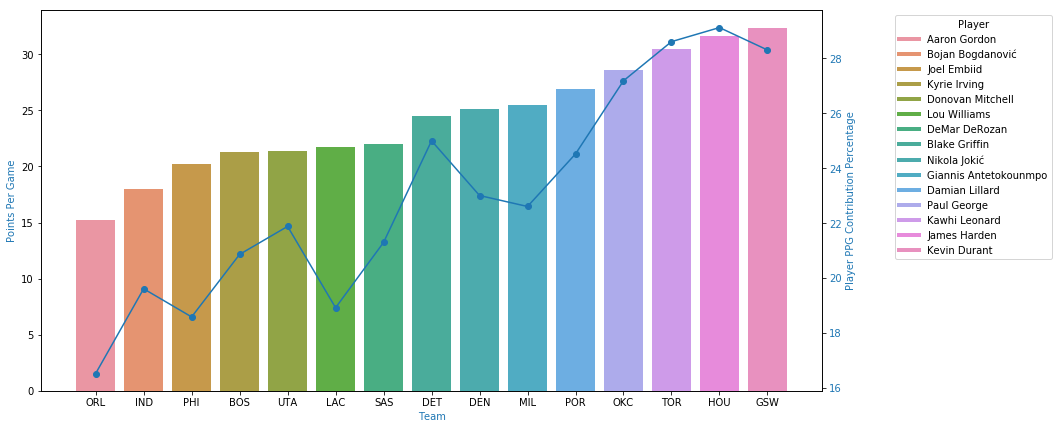

In [33]:
# Leading players of each team in scoring
# Here idx is a Series object of True / False for each player depending on whether the condition is met
idx = player_all_data.groupby(['Team'])['PTS'].transform(max) == player_all_data['PTS']
# Based on the idx returned we get the player's name (not only Tm and Points)
top_player_ppg = player_all_data[idx][['Team', 'Player', 'PTS']]

# Merge data frames to have one source of input
df = pd.merge(top_player_ppg, team_data.loc[:, ['Team', 'PTS']].rename(columns={'PTS' : 'Tm PPG'})  \
              , on='Team').sort_values('PTS')

# Share of each player's PPG to team's PPG 
df['Player To Tm PPG Ratio'] = (df['PTS'] / df['Tm PPG'])*100  # This is percentage

# Will use it later for the legend
auxlist = df['Player'].tolist()

# Initialize Figure and Axes object
fig, ax = plt.subplots(figsize=(14,7))

# Create bar plot
ax = sns.barplot(x='Team', y="PTS", data=df)

# Get the color of each bar
bars = [r for r in ax.get_children() if type(r)==Rectangle]
barcolors = [c.get_facecolor() for c in bars[:-1]] # I think the last Rectangle is the background.

# Create a tuple with the name and the color for each team
legend_elements = []
for element, color in zip(auxlist, barcolors):
    legend_elements.append(Line2D([0], [0], color=color, lw=4, label=element))
                              
# Create the legend and locate it outside the plot. The handles are matched with the color of each bar
ax.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1), loc='upper right', fontsize='medium', title='Player')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax.set_xlabel('Team', color=color)
ax.set_ylabel('Points Per Game', color=color)
ax2.set_ylabel('Player PPG Contribution Percentage', color=color)  
ax2.plot(df['Team'], df['Player To Tm PPG Ratio'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Show plot
plt.show()

## Report 3: Assist and Usage Rate of Teams' Key Players


First things first:

| Definitions | Explanation|
|--|:--|
| Key Player  |  A player with more than 11 playoff games, which averaged >= 30 mins >= 0.2 Turnovers per game |
| Assists Rate | |
| Usage Rate | |

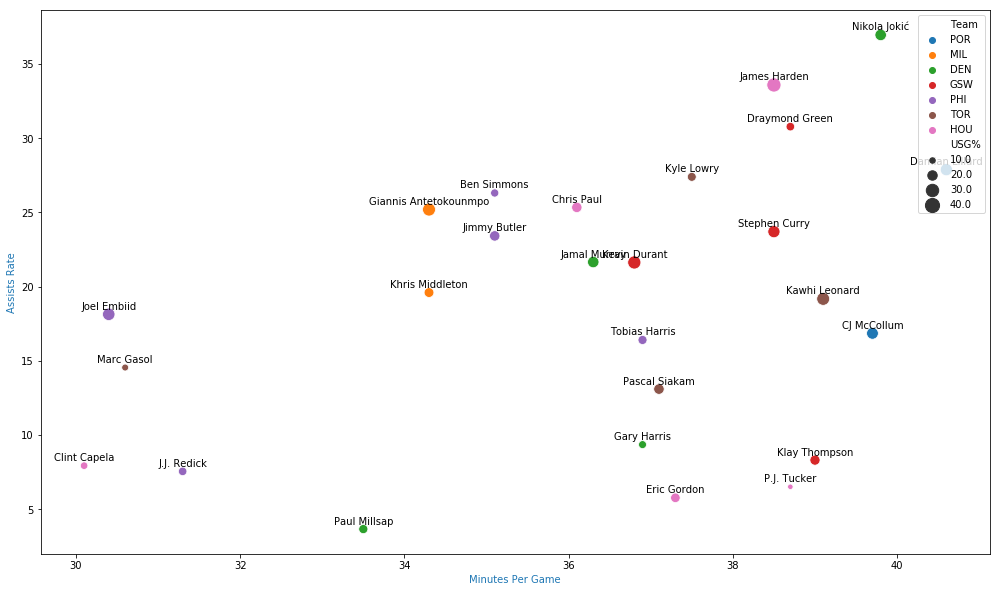

In [34]:
# Set criteria as thresholds:
thresholds = Thresholds(11,30,0.2)

# Filter rows based on thresholds
analysis = player_all_data[(player_all_data.G >= thresholds.games) &   \
                                  (player_all_data.MP > thresholds.mpg) & (player_all_data.TOV > thresholds.tov)]



fig, ax = plt.subplots(figsize=(17,10))
sns.scatterplot(x='MP', y='Assists Rate', hue = 'Team'  \
                , size='USG%', sizes=(30, 200), data=analysis)

# Add labels beside each point of the diagram (using the zip function)
for x,y,z in zip(analysis['MP'].tolist(),  \
                 analysis['Assists Rate'].tolist(),  \
                 analysis['Player'].tolist()
                ):
    label = z     

    # Annotate each label next to point
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center        

ax.legend(loc='upper right', fontsize='medium')
color = 'tab:blue'
ax.set_xlabel('Minutes Per Game', color=color)
ax.set_ylabel('Assists Rate', color=color)
plt.show()